# Stereo Estimation Using Patch Matching

Depth Estimation in computer vision is most commonly done via stereo vision in which images from two cameras are used to triangulate and estimate distances.

The simplest example of stereo pair images is vision in left eye and right eye. Both eyes sees a real world 3D point but the image point in right image plane is shifted horizantally w.r.t left image plane.

Another instance of Stereo Problem is the roadside trees move faster while you are travelling when compared to farther mountains. 
The following link helps in better understanding of problem. http://www.cs.tut.fi/~suominen/SGN-1656-stereo/stereo_instructions.pdf


In [1]:
from __future__ import division
import PIL

import numpy as np
import cv2

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

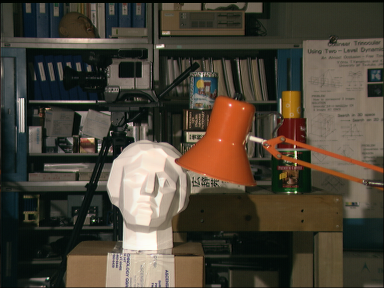

In [2]:
#Display Left image
Image(filename='./data/left_t.png')

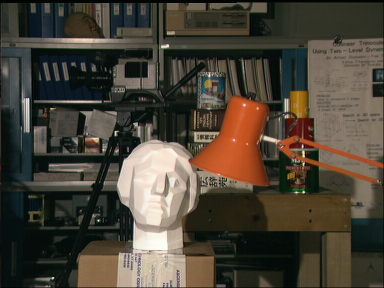

In [3]:
#Display Right Image. Observe the difference in both images
Image(filename='./data/right_t.png')

# Geometry Of Stereo Images

Let us assume the two cameras which were used to capture Left and Right images have same focal length $f$. 

Let the two cameras are separated by a baseline distance $B$ as shown in the figure below.

Since, both cameras have same focal length their image planes are separated along horizantal axis only.

Let P be the real world point which is at distance $Z$ from both the cameras.

$Disparity$ is the displacement of an Image point of a real world point in one image w.r.t other image. 

From similar triangles, we can figure out that $x_1$ - $x_2$=$Bf/Z$

We can realize that disparity is inversely proportional to the distance of point from the cameras. Farther the point the smaller is disparity. Hence, mountains appear to move slowly while roadside trees move rapidly

<img src='./temp/Disparity.png' width="450" height="450">

The basic step in computing stereo is Identifying common points in camera views. We have appearance as the clue to identify them. 

In [4]:
left = cv2.imread('./data/left_t.png', 0)
right = cv2.imread('./data/right_t.png', 0)
print('Left Shape ' + str(left.shape))
print('Right Shape ' + str(right.shape))

Left Shape (288, 384)
Right Shape (288, 384)


In [5]:
#Display and save the image
def match(disparity, save):
    plt.imshow(disparity)

# How Images can be matched

The image matching problems can be divided into two classes of algorithms. 

a. Correlation Based Algorithms which produces dense correspondence (pixel to pixel)
<br>
b. Features Based Algorithms which produces sparse correspondences

Images in RGB space has color as characteristic. Hence, having color as heuristic to match several images makes sense.
But, by matching individual pixel colours, matching will be too noisy.

Match a (small) neighbourhood of colours from one image to a similar neighbourhood in other. We will typically need geometric constraints to reduce the size of the search space

Algorithm:
Extract a patch in the left image centered around (x,y).
<br>
Because of the assumptions made, search for an "appropriate" patch in the right image along the X directions of the patch in left image.
<br>
At each location (x,y) store the displacement of appropriate patch from the right patch

Because of assumptions made, the procedure will work if local surface is fronto-parallel and images have similar magnification i.e. skewed images or two differently zoomed images might face issues. Why?

However, if we have left and right images has variance in contrast etc. matching pixel neighbourhood might not help as the color of the texture in the patch is no longer same and matches will be noisy.

Hence, matching in feature space will help as features will be invariant to variations in illumination, scale, rotations etc. 

Let's match images. But How do you decide appropriate patch? We choose them using various similarity measures as mentioned below

# Sum of Squared Distances

This is the most popular matching score. It is also used in deriving Harris Corner. Search for a patch in the right image along X direction whose Euclidean distance is very small to the patch in left image

<img src='./temp/ssd.png' width="350" height="350">


In [6]:
def ssd_match(left, right, patch, search_range):
    """
    Assume both left and right images have same dimensions
    :type left: OpenCv Image
    
    Params: 
    left: Left image
    right: Right Image which is shifted along X-Axis
    Patch: Size of a patch around each pixel
    search_range: How many pixels in the right image are searched for a particular pixel in left image
    """
    
    # Can reduce image size by half 
    #left = cv2.resize(left, (0, 0), fx=0.5, fy=0.5)
    #right = cv2.resize(right, (0, 0), fx=0.5, fy=0.5)
    w, h = left.shape

    # Store the displacement of each pixel in disparity
    disparity = np.zeros((w, h), np.uint8)
    disparity.shape = w, h
    patch_half = int(patch / 2)

    offset_adjust = 255 / search_range
    #Each Column
    for y in range(patch_half, w - patch_half - 1):
        #print y
        #Each Row
        for x in range(patch_half, h - patch_half - 1):
            best_match = 0 # best_match stores the displacement of appropriate patch
            best_score = 65534 # best_score stores the current best score. Smaller the score the better is the patch
            # Extract patch from left image around (x,y). patch_half pixels to the left, right, top and above 
            left_patch = left[y - patch_half:y + patch_half, x - patch_half:x + patch_half]
            # How many pixels to search 
            for search in range(search_range):
                ssd = 0
                ssd_temp = 0
                if x + search + patch_half < h + 1:
                    # slide one pixel in the right image and extract the patch around (x+search, y)
                    right_patch = right[y - patch_half:y + patch_half,
                                          x + search - patch_half:(x + search + patch_half)]
                    for i in range(left_patch.shape[0]):
                        for j in range(right_patch.shape[1]):
                                '''
                                Sum of Squared distances is computed here
                                '''
                                ssd_temp = int(left_patch[i,j]) - int(right_patch[i,j])
                                ssd += ssd_temp * ssd_temp
                    #If the current score is less than the previous best score, then it is a better match
                    if ssd < best_score:
                        best_score = ssd
                        best_match = search
            disparity[y, x] = best_match * offset_adjust
    return disparity

In [7]:
dis_ssd = ssd_match(left, right, 8, 10)

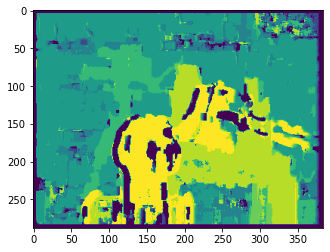

In [8]:
match(dis_ssd, '')

# Normalized Cross Correlation

When a scene is imaged by different sensors, or under different illumination intensities, the SSD can be large for windows representing the same area in the scene

A solution is to normalize the pixels in the patches before comparing them by subtracting the mean of the patch intensities and dividing by standard deviation

<img src='./temp/ncc_1.png' width="350" height="350">
<img src='./temp/ncc_2.png' width="350" height="350">

    where C is Correlation
    
Important point about NCC:
<br>
Score values range from 1 (perfect match) to -1 (completely anti-correlated)

In [9]:
def ncc_match(left, right, patch, search_range):
    """
    Assume both left and right images have same dimensions
    :type left: OpenCv Image
    """

    #left = cv2.resize(left, (0, 0), fx=0.5, fy=0.5)
    #right = cv2.resize(right, (0, 0), fx=0.5, fy=0.5)
    w, h = left.shape

    disparity = np.zeros((w, h), np.uint8)
    disparity.shape = w, h
    patch_half = int(patch / 2)

    offset_adjust = 255 / search_range
    
    for y in range(patch_half, w - patch_half - 1):
        #print y
        for x in range(patch_half, h - patch_half - 1):
            #Extract Left Patch
            left_patch = left[y - patch_half:y + patch_half, x - patch_half:x + patch_half]
            #Compute Mean of the left patch
            left_mu = np.mean(left_patch)
            #Compute the Standard deviation of the left patch
            left_sigma = np.std(left_patch)
            # Best Score should be greater for best match unlike SSD where it should be smaller
            best_score = -1
            for search in range(search_range):
                if x + search + patch_half < h + 1:
                    #Extract right patch
                    right_patch = right[y - patch_half:y + patch_half,
                                      x + search - patch_half:(x + search + patch_half)]
                    # Mean of the right patch
                    right_mu = np.mean(right_patch)
                    # Std of the right Patch
                    right_sigma = np.std(right_patch)
                    num = np.mean((left_patch - left_mu) * (right_patch - right_mu))
                    denom = left_sigma * right_sigma
                    score = num / denom
                # Assign the current score as the best score if it is greater than the previous best score
                if score > best_score:
                    best_score = score
                    best_match = search
            disparity[y, x] = best_match * offset_adjust
    return disparity

In [10]:
dis_ncc = ncc_match(left, right, 8, 10)

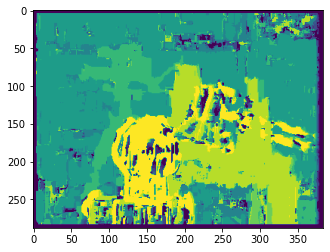

In [11]:
match(dis_ncc, '')

# Cosine Similarity

Consider each patch as a vector. The dot product between the left patch and right patch gives the similarity information

<img src='./temp/cosine.png' width="350" height="350">


In [12]:
def cosine_match(left, right, patch, search_range):
    """
    Assume both left and right images have same dimensions
    :type left: OpenCv Image
    """

    #left = cv2.resize(left, (0, 0), fx=0.5, fy=0.5)
    #right = cv2.resize(right, (0, 0), fx=0.5, fy=0.5)
    w, h = left.shape

    disparity = np.zeros((w, h), np.uint8)
    disparity.shape = w, h
    patch_half = int(patch / 2)
    eps=0.00001
    offset_adjust = 255 / search_range
    
    for y in range(patch_half, w - patch_half - 1):
        #print y
        for x in range(patch_half, h - patch_half - 1):
            left_patch = left[y - patch_half:y + patch_half, x - patch_half:x + patch_half]
            best_score = -1
            for search in range(search_range):
                if x + search + patch_half < h + 1:
                        #Convert left patch to a vector
                        left_flatten = left_patch.flatten()[0]
                        #Right patch
                        right_patch = right[y - patch_half:y + patch_half,
                                      x + search - patch_half:(x + search + patch_half)]
                        # Convert right patch to a vector
                        right_flatten = right_patch.flatten()[0]
                        #Compute Dot product 
                        dot = np.dot(left_flatten, right_flatten)
                        # Compute magnitudes
                        left_magnitude = np.linalg.norm(left_flatten)
                        right_magnitude = np.linalg.norm(right_flatten)
                        score = dot / (left_magnitude * right_magnitude+ eps)
                        
                if score > best_score:
                        best_score = score
                        best_match = search
            disparity[y, x] = best_match * offset_adjust
    return disparity

In [13]:
dis_cos = cosine_match(left, right, 8, 10)

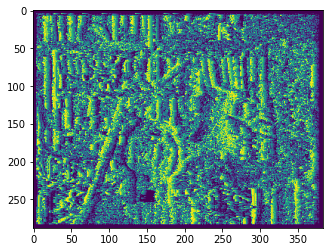

In [14]:
match(dis_cos, '')

# In Feature Space

In [15]:
left_img = np.float32(left) / 255.0
gx_left = cv2.Sobel(left_img, cv2.CV_32F, 1, 0, ksize=5)
gy_left = cv2.Sobel(left_img, cv2.CV_32F, 0, 1, ksize=5)
laplacian_left = cv2.Laplacian(left,cv2.CV_64F)

mag_left, angle_left = cv2.cartToPolar(gx_left, gy_left, angleInDegrees=True)

right_img = np.float32(right) / 255.0
gx_right = cv2.Sobel(right_img, cv2.CV_32F, 1, 0, ksize=5)
gy_left = cv2.Sobel(right_img, cv2.CV_32F, 0, 1, ksize=5)

mag_right, angle_right = cv2.cartToPolar(gx_left, gy_left, angleInDegrees=True)

In [16]:
dis_ncc_sobel = ssd_match(mag_left, mag_right, 8, 10)

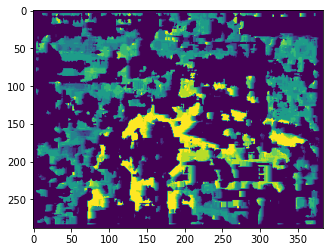

In [17]:
match(dis_ncc_sobel,'')

# What happens if just take the histogram of normal gradients

In [18]:
def gradient_match(left_ang, right_ang, num_bins, search_range, patch):
    
    metric = 'ssd'
    """
    Assume both left and right images have same dimensions
    :type left: OpenCv Image
    """

    left_ang = cv2.resize(left_ang, (0, 0), fx=0.5, fy=0.5)
    right_ang = cv2.resize(right_ang, (0, 0), fx=0.5, fy=0.5)
    w, h = left_ang.shape
    disparity = np.zeros((w, h), np.uint8)
    disparity.shape = w, h
    
    #Spacing between bins
    bin_offset = int(360/num_bins)
    # Bin values
    bins_vals = range(0,360,bin_offset)
    patch_half = int(patch / 2)
    offset_adjust = 255 / search_range
    
    for y in range(patch_half, w - patch_half - 1):
        for x in range(patch_half, h - patch_half - 1):
            left_patch = left_ang[y - patch_half:y + patch_half, x - patch_half:x + patch_half]
            #Compute histogram of left patch
            left_hist =  np.histogram(left_patch, bins_vals)[0][0]
            best_score = 65534
            for search in range(search_range):
                if x + search + patch_half < h + 1:
                        #Right patch
                        right_patch = right_ang[y - patch_half:y + patch_half,
                                      x + search - patch_half:(x + search + patch_half)]
                        # Compute histogram of right image
                        right_hist =  np.histogram(right_patch, bins_vals)[0][0]
                        
                        ssd_t = np.linalg.norm(left_hist - right_hist)
                        score = ssd_t
                        if score < best_score: #and score != 0:
                            best_score = score
                            best_match = search
                #print best_score
            disparity[y, x] = best_match * offset_adjust
            #disparity[y, x] = best_match 
    return disparity


In [19]:
dis_ang = gradient_match(angle_left, angle_right, 6, 15, 6)


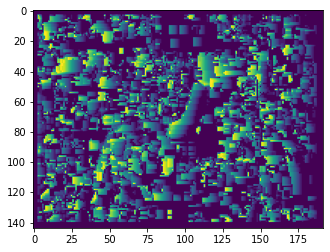

In [20]:
match(dis_ang,'')

# Using Open CV

It uses the technique described in the paper "Stereo processing by semiglobal matching and mutual information."

[Hirschmüller](https://www.ncbi.nlm.nih.gov/pubmed/18084062)


In [23]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

imgL = right
imgR = left

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)

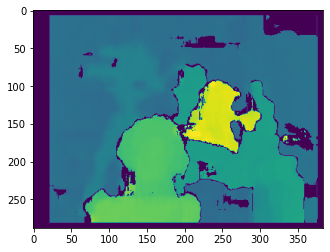

In [24]:
match(disparity,'')